# T-SNE Embedding of the Program Batabase

In [1]:
import sys
sys.path.append('/home/lars-quaedvlieg/projects/evotune/src')

In [2]:
import os.path
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

method = 'evotune'
task = 'bin'

programdb_dir_path = f"../../out/{task}/{method}/"
programdb_name_func = lambda round_num: f"programbank_graniteicmls2_6_bin_{round_num}.pkl"

In [32]:
from transformers import AutoModel, AutoTokenizer

model_name = "chandar-lab/NeoBERT" # "bert-base-uncased", "chandar-lab/NeoBERT", "allenai/longformer-base-4096"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

## Getting the embeddings

In [35]:
all_functions = []
all_island_idxs = []
all_round_nums = []
all_function_scores = []

prev_islands_functions = defaultdict(list)
pbar = tqdm(range(100, 2800, 100))
for round_num in pbar:
    programdb = pickle.load(open(os.path.join(programdb_dir_path, programdb_name_func(round_num)), "rb"))
    for island_idx, island in enumerate(programdb._islands):
        all_island_functions = []
        for cluster_score, cluster in island._clusters.items():
            for func in cluster._programs:
                all_island_functions.append(func) # TODO: Keep only what's inside the function definition
        diff_functions_counter = Counter(all_island_functions) - Counter(prev_islands_functions[island_idx])
        diff_functions_island_new = list(diff_functions_counter.elements())
        for diff_func in diff_functions_island_new:
            all_functions.append(diff_func)
            all_island_idxs.append(island_idx)
            all_round_nums.append(round_num)
            all_function_scores.append(cluster_score)
        prev_islands_functions[island_idx] = all_island_functions

all_lengths = [len(tokenizer(func_str)["input_ids"]) for func_str in all_functions]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.11it/s]


In [ ]:
# Compute histogram of token lengths
plt.figure(figsize=(8, 6))
plt.hist(all_lengths, bins=50, alpha=0.7)
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.title("Histogram of token counts per function")
plt.show()

In [ ]:
import torch

batch_size = 32  # Adjust according to your GPU memory

# Create a DataLoader-like batching for tokenization
def batch_tokenize(functions, batch_size=32):
    for i in range(0, len(functions), batch_size):
        batch = functions[i:i+batch_size]
        yield tokenizer(batch, return_tensors="pt", padding=True, truncation=True)

all_functions_embeddings = []

model.eval()  # Put the model in eval mode
model.to('cuda')  # Move model to GPU if available

with torch.no_grad():
    for batch_inputs in tqdm(batch_tokenize(all_functions, batch_size=batch_size)):
        batch_inputs = {k: v.to('cuda') for k, v in batch_inputs.items()}
        outputs = model(**batch_inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embeddings
        all_functions_embeddings.append(embeddings.cpu())

# Stack all embeddings into a single tensor or numpy array
all_functions_embeddings = torch.cat(all_functions_embeddings, dim=0).numpy()

In [9]:
print(all_functions_embeddings.shape)

NameError: name 'all_functions_embeddings' is not defined

In [ ]:
# Save embeddings
# torch.save(all_functions_embeddings, f"../../out/{task}/{method}/all_functions_embeddings_neobert.pt")

## Create the t-SNE visualization

In [17]:
import torch
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

def load_and_embed_tsne(task, method):
    programdb_dir_path = f"../../out/{task}/{method}/"
    programdb_name_func = lambda round_num: f"{round_num}.pkl"

    all_functions = []
    all_island_idxs = []
    all_round_nums = []
    all_function_scores = []

    prev_islands_functions = defaultdict(list)

    for round_num in tqdm(range(100, 2800, 100), desc=f"{task} – {method}"):
        path = os.path.join(programdb_dir_path, programdb_name_func(round_num))
        programdb = pickle.load(open(path, "rb"))
        for island_idx, island in enumerate(programdb._islands):
            all_island_functions = []
            for cluster_score, cluster in island._clusters.items():
                for func in cluster._programs:
                    all_island_functions.append(func)

            diff_functions_counter = Counter(all_island_functions) - Counter(prev_islands_functions[island_idx])
            diff_functions_island_new = list(diff_functions_counter.elements())

            for func in diff_functions_island_new:
                all_functions.append(func)
                all_island_idxs.append(island_idx)
                all_round_nums.append(round_num)
                all_function_scores.append(cluster_score)

            prev_islands_functions[island_idx] = all_island_functions

    # Convert functions to embeddings

    tsne_path = os.path.join(programdb_dir_path, "tsne_embeddings.pt")
    if not os.path.exists(tsne_path):
        embeddings = torch.load(open(os.path.join(programdb_dir_path, "all_functions_embeddings_neobert.pt"), "rb"))
    
        # t-SNE
        tsne = TSNE(n_components=2, random_state=40, perplexity=30, max_iter=1000)
        embeddings_2d = tsne.fit_transform(embeddings)
    
        # Save t-SNE if desired
        torch.save(embeddings_2d, tsne_path)

    embeddings_2d = torch.load(open(tsne_path, "rb"))
    
    df = pd.DataFrame(embeddings_2d, columns=["x", "y"])
    df["Sampling Budget"] = [num * 8 for num in all_round_nums]
    df["island"] = all_island_idxs
    df["score"] = all_function_scores

    return df

In [13]:
def plot_island_tsne(ax, df, font_family, font_ticks, title=None, display_legend=False):
    custom_colors = [
        "#3b00ff", "#ff7f0e", "#2ca02c",
        "#d62728", "#9467bd", "#17becf"
    ]
    sns.set_palette(custom_colors)

    sns.scatterplot(
        ax=ax,
        data=df,
        x='x',
        y='y',
        hue=df['island'].astype(str),
        s=40,
        alpha=0.9,
        edgecolor='white',
        linewidth=0.3,
        legend=display_legend
    )
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_aspect('equal')

    if display_legend:
        legend = ax.legend(
            loc="lower right",
            fontsize=12,
            frameon=True,
            handlelength=1.1,
            title="Island",
            labelspacing=0.4,
            borderpad=0.8,
        )
        for handle in legend.legend_handles:
            handle.set_markersize(8)
        for text in legend.get_texts():
            text.set_fontfamily(font_family)
            text.set_fontsize(10)
        legend.get_title().set_fontsize(12)
        legend.get_title().set_fontfamily(font_family)
        legend.get_frame().set_edgecolor("grey")
        legend.get_frame().set_alpha(0.9)

    if title:
        ax.set_title(title, fontsize=16, fontfamily=font_family)

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_round_tsne(ax, df, font_family, title=None, display_cbar=False):
    custom_colors = [
        "#3b00ff", "#ff7f0e", "#2ca02c",
        "#d62728", "#9467bd", "#17becf"
    ]

    sns.scatterplot(
        ax=ax,
        data=df,
        x='x',
        y='y',
        hue='Sampling Budget',
        palette=sns.color_palette("viridis", as_cmap=True),
        legend=False,
        s=40,
        alpha=0.9,
        edgecolor='white',
        linewidth=0.3
    )
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    for idx, (island, group) in enumerate(df.groupby('island')):
        sns.kdeplot(
            ax=ax,
            x=group['x'],
            y=group['y'],
            levels=1,
            color=custom_colors[idx],
            linewidths=1.5,
            alpha=0.5,
            zorder=0
        )

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_aspect('equal')

    # Colorbar
    if display_cbar:
        norm = plt.Normalize(df['Sampling Budget'].min(), df['Sampling Budget'].max())
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        sm.set_array([])
    
        axins = inset_axes(ax, width="3%", height="25%", loc='lower right',
                           bbox_to_anchor=(-0.02, 0.02, 1, 1),
                           bbox_transform=ax.transAxes,
                           borderpad=0)
        
        cbar = plt.colorbar(sm, cax=axins)
        cbar.set_label("Sampling\nBudget", fontsize=14, labelpad=10)
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.yaxis.label.set_family(font_family)
        for label in cbar.ax.get_yticklabels():
            label.set_family(font_family)
        cbar.ax.yaxis.set_label_position('left')
        cbar.ax.yaxis.set_ticks_position('left')

        # Hide the default label
        cbar.ax.set_ylabel("")
        
        # Manually add a text label at a custom position
        cbar.ax.text(
            -4.5, 0.5, "Sampling\nBudget",
            rotation=90,
            fontsize=14,
            fontfamily=font_family,
            va='center',
            ha='center',
            transform=cbar.ax.transAxes
        )

    if title:
        ax.set_title(title, fontsize=16, fontfamily=font_family)

In [25]:
tasks = ["bin", "tsp", "flatpack"]
titles = ["Bin Packing", "Travelling Salesman Problem", "FlatPack"]

from tqdm import tqdm
dfs_evotune = [load_and_embed_tsne(task, "evotune") for task in tqdm(tasks)]
dfs_funsearch = [load_and_embed_tsne(task, "funsearch") for task in tqdm(tasks)]

bin – evotune: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.70it/s]
/tmp/ipykernel_2678/741924172.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start sett

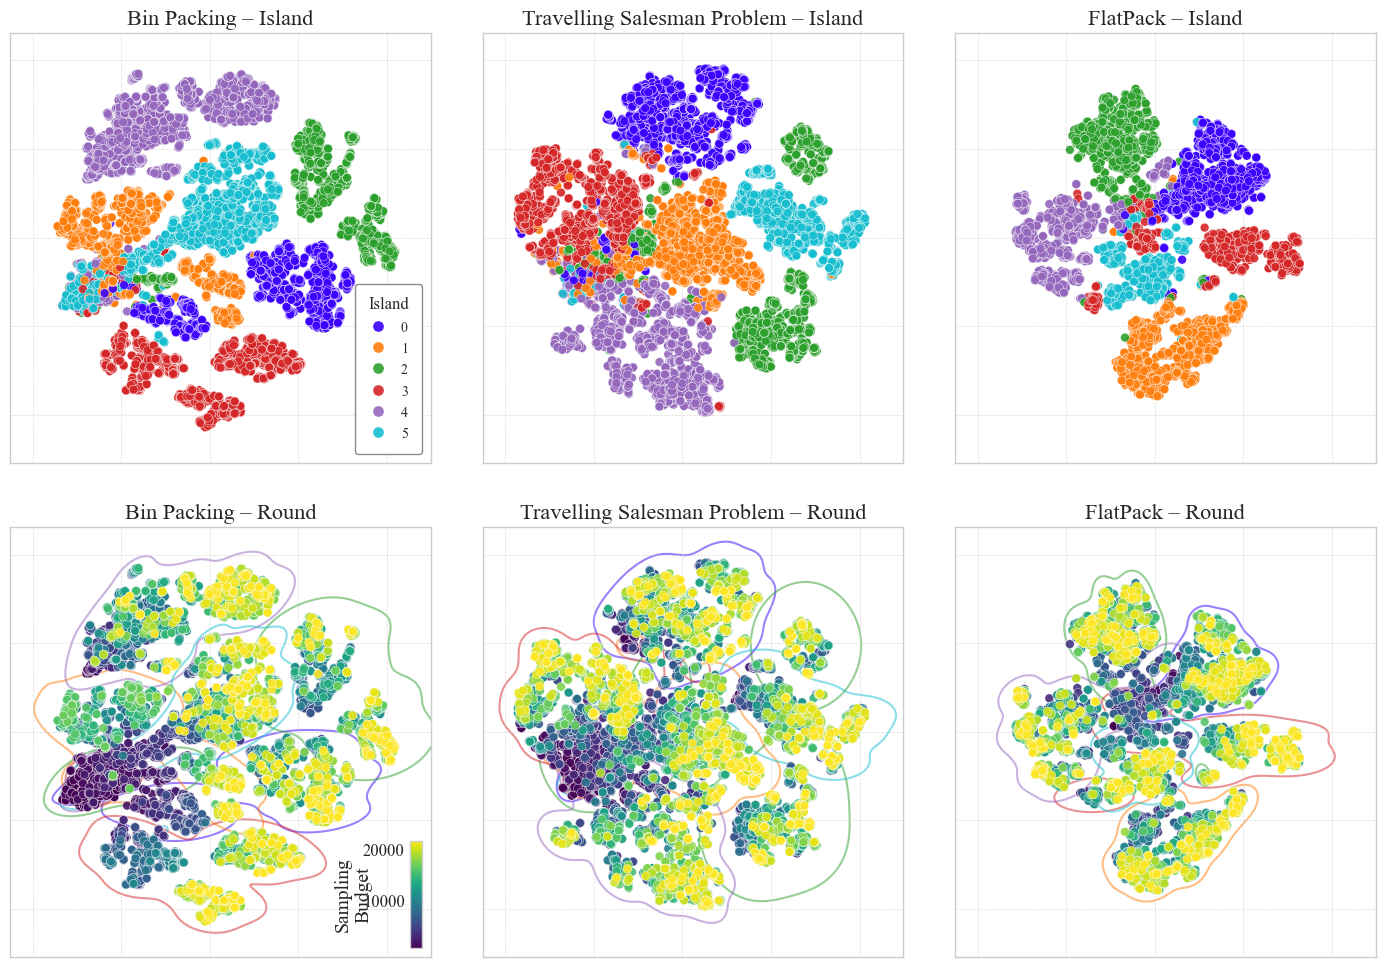

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'

def plot_grid(dfs, titles, output_path):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    for col, (df, title) in enumerate(zip(dfs, titles)):
        plot_island_tsne(
            axes[0, col],
            df,
            font_family='Times New Roman',
            font_ticks=14,
            title=f"{title} – Island",
            display_legend=(col == 0)
        )
        plot_round_tsne(
            axes[1, col],
            df,
            font_family='Times New Roman',
            title=f"{title} – Round",
            display_cbar=(col == 0)
        )

    def get_global_limits(dfs):
        xmin = min(df["x"].min() for df in dfs)
        xmax = max(df["x"].max() for df in dfs)
        ymin = min(df["y"].min() for df in dfs)
        ymax = max(df["y"].max() for df in dfs)
        return xmin, xmax, ymin, ymax

    xmin, xmax, ymin, ymax = get_global_limits(dfs)
    for ax in axes.flat:
        ax.set_xlim(xmin - 20, xmax + 20)
        ax.set_ylim(ymin - 20, ymax + 20)
        ax.set_aspect("equal", adjustable="box")

    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    plt.savefig(output_path, format="pdf")
    plt.savefig(output_path.replace(".pdf", ".png"), format="png", dpi=300)
    plt.show()

# Plot both
plot_grid(dfs_evotune, titles, "tsne_grid_evotune.pdf")
plot_grid(dfs_funsearch, titles, "tsne_grid_funsearch.pdf")

## Plot Individually

In [ ]:
import torch
all_functions_embeddings = torch.load(open(f"../../out/{task}/{method}/all_functions_embeddings_neobert.pt", "rb"))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Compute t-SNE embedding
tsne = TSNE(n_components=2, random_state=40, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(all_functions_embeddings)

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'island': [idx + 1 for idx in all_island_idxs],
    'round': all_round_nums,
    'length': all_lengths,
    'score': all_function_scores
})

font_family = "Times New Roman"
font_ticks = 18

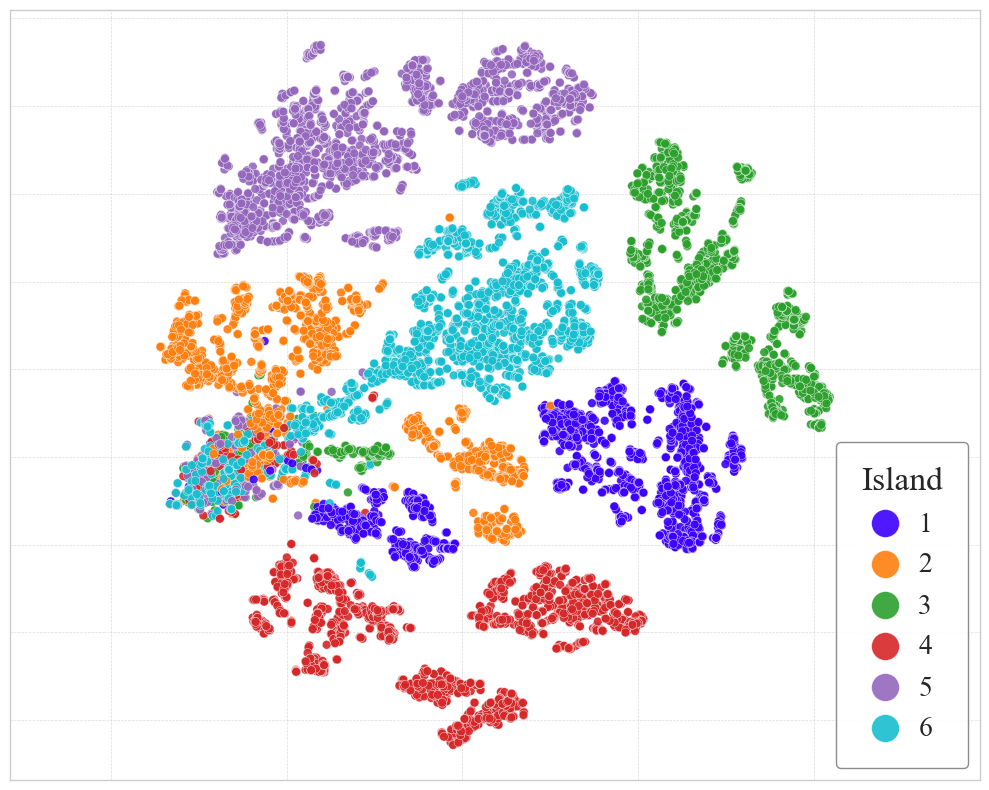

In [232]:
# Plot using seaborn
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = font_family


plt.figure(figsize=(10, 8))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

custom_colors = [
    "#3b00ff",  # muted blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#17becf"   # cyan (replaces brown, high contrast and crisp)
]

sns.set_palette(custom_colors)

sns.scatterplot(data=df, x='x', y='y', hue=df['island'].astype(str), s=40, alpha=0.9, edgecolor='white', linewidth=0.3)
# plt.title('t-SNE of Python Functions Embeddings by Island')
legend = plt.legend(loc="lower right",
                   fontsize=font_ticks,
                   frameon=True,
                   handlelength=1.1,
                   title="Island", labelspacing=0.6, borderpad=1
                   )

# for idx, (island, group) in enumerate(df.groupby('island')):
#     sns.kdeplot(
#         x=group['x'], y=group['y'],
#         levels=[0.1],
#         color=custom_colors[idx],
#         linewidths=1,
#         alpha=0.3,
#         zorder=0  # keeps it behind the scatter
#     )

# Remove axis labels and title
plt.xlabel("")
plt.ylabel("")

plt.axis('equal')

# Keep ticks but hide their labels (so grid remains)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

legend.get_frame().set_edgecolor("grey")  # Set frame color
legend.get_frame().set_alpha(0.9)  # Set legend transparency

for handle in legend.legend_handles:
    handle.set_markersize(20)  # Default is ~6; try 10–12

# legend = plt.legend(title='Island', bbox_to_anchor=(1.05, 1), loc='upper left')
for text in legend.get_texts():
    text.set_fontfamily(font_family)
    text.set_fontsize(20)
legend.get_title().set_fontsize(24)

legend.get_title().set_fontfamily(font_family)  # Fixed this line
plt.tight_layout()
plt.savefig("tsne_plot_island.pdf", format="pdf", bbox_inches="tight")  # Save to PDF
plt.show()

/tmp/ipykernel_1707/1582340695.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


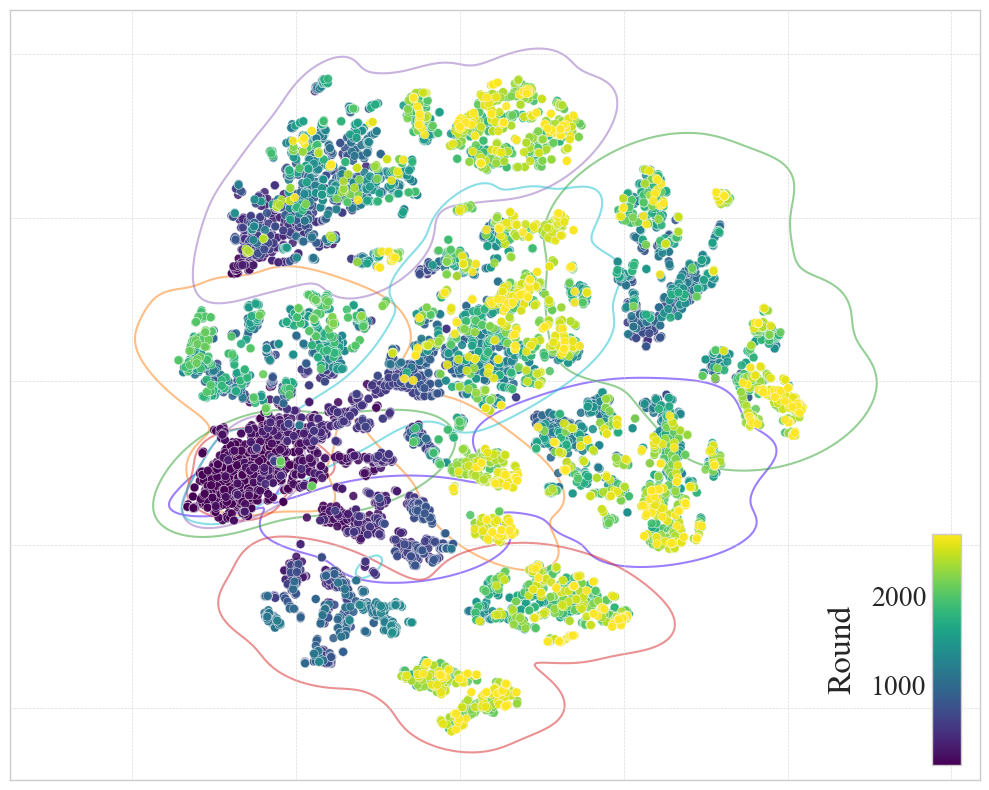

In [233]:
# Plot using seaborn
plt.figure(figsize=(10, 8))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

sns.scatterplot(data=df, x='x', y='y', hue='round', palette=sns.color_palette("viridis", as_cmap=True), legend=False, s=40, alpha=0.9, edgecolor='white', linewidth=0.3)

for idx, (island, group) in enumerate(df.groupby('island')):
    sns.kdeplot(
        x=group['x'], y=group['y'],
        levels=1,
        color=custom_colors[idx],
        linewidths=1.5,
        alpha=0.5,
        zorder=0  # keeps it behind the scatter
    )

# Remove axis labels and title
plt.xlabel("")
plt.ylabel("")

plt.axis('equal')

# Keep ticks but hide their labels (so grid remains)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])


# After sns.scatterplot(..., legend=False)
norm = plt.Normalize(df['round'].min(), df['round'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Inset colorbar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(
    plt.gca(),
    width="3%",
    height="30%",
    loc='lower right',
    bbox_to_anchor=(-0.02, 0.02, 1, 1),  # shift left
    bbox_transform=plt.gca().transAxes,
    borderpad=0
)
cbar = plt.colorbar(sm, cax=axins)
cbar.set_label("Round", fontsize=24, labelpad=10)
cbar.ax.tick_params(labelsize=20)

cbar.ax.yaxis.label.set_family(font_family)
for label in cbar.ax.get_yticklabels():
    label.set_family(font_family)

cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.savefig("tsne_plot_rounds.pdf", format="pdf", bbox_inches="tight")  # Save to PDF
plt.show()

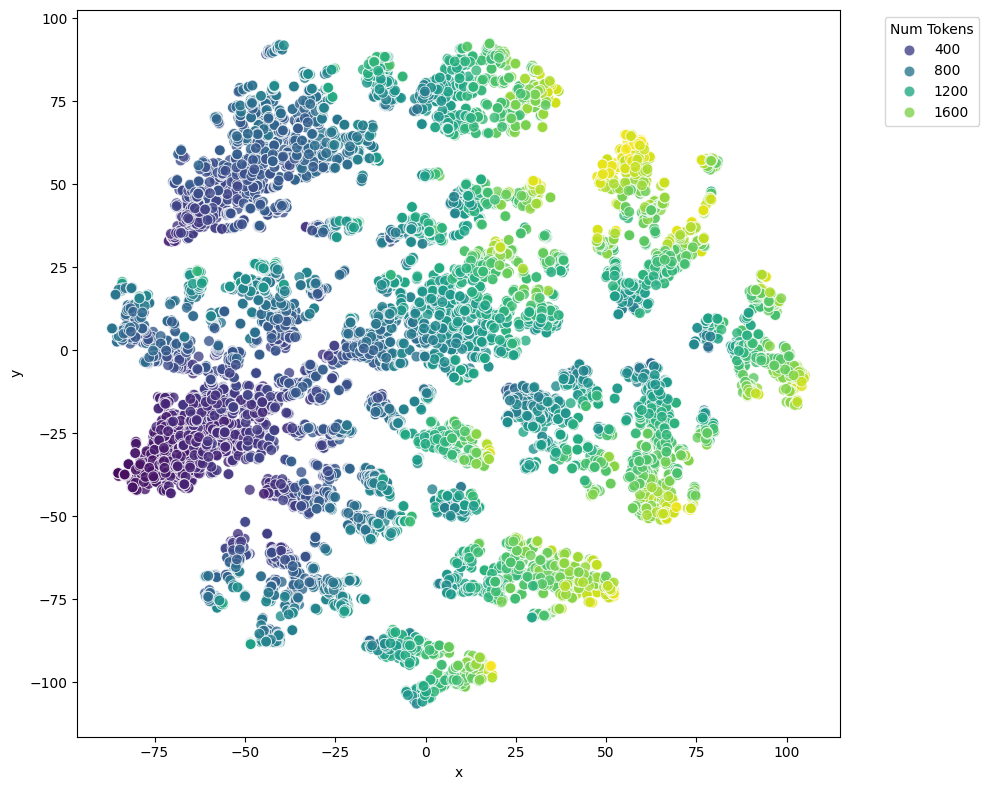

In [41]:
# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='x', y='y', hue='length', palette='viridis', s=60, alpha=0.8)
# plt.title('t-SNE of Python Functions Embeddings by Function Length in Tokens')
plt.legend(title='Num Tokens', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1707/1423123686.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=score_df, x='x', y='y', hue='score', palette='viridis', s=60, alpha=0.8)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


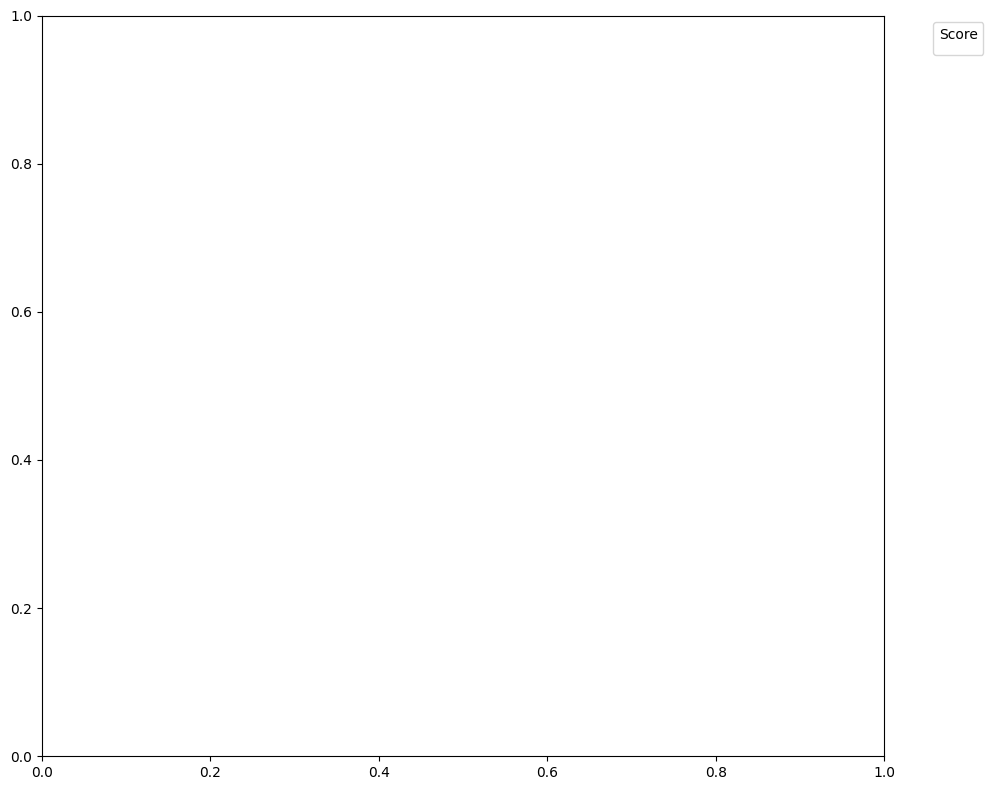

In [42]:
# Plot using seaborn
score_df = df[df['score'] >= -300]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=score_df, x='x', y='y', hue='score', palette='viridis', s=60, alpha=0.8)
# plt.title('t-SNE of Python Functions Embeddings by Frequency')
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# TODO inter-cluster communication vs funsearch?